In [1]:
# setting my si data frame
import pandas as pd
data = '/workspaces/service-data/outputs/si.csv'
si = pd.read_csv(data, sep=';')


In [2]:
from datetime import datetime
import pytz

# Specify the timezone
timezone = pytz.timezone("America/Montreal")

# Get the current date and time in the specified timezone
current_date = datetime.now(timezone)

# Format the current date and time into the desired string format
current_datestr = current_date.strftime("%Y-%m-%d_%H:%M:%S")

# Print the current date and time
print(f"current date: {current_datestr}")


current date: 2025-04-08_09:18:56


In [3]:
# want to view my column names
colnames = si.columns.tolist()
print(colnames)

['fiscal_yr', 'service_id', 'service_name_en', 'service_name_fr', 'service_description_en', 'service_description_fr', 'service_type', 'service_recipient_type', 'service_scope', 'client_target_groups', 'program_name_en', 'program_name_fr', 'client_feedback_channel', 'service_fee', 'last_GBA', 'ident_platform', 'ident_platform_comments', 'os_account_registration', 'os_authentication', 'os_application', 'os_decision', 'os_issuance', 'os_issue_resolution_feedback', 'os_comments_client_interaction_en', 'os_comments_client_interaction_fr', 'how_has_the_service_been_assessed_for_accessibility', 'last_service_review', 'last_service_improvement', 'sin_usage', 'cra_bn_identifier_usage', 'num_phone_enquiries', 'num_applications_by_phone', 'num_website_visits', 'num_applications_online', 'num_applications_in_person', 'num_applications_by_mail', 'num_applications_by_email', 'num_applications_by_fax', 'num_applications_by_other', 'special_remarks_en', 'special_remarks_fr', 'service_uri_en', 'service

In [4]:
# to add a new column for phone apps inquiries
# phone apps inquiries are num_phone_enquiries plus num_applications_by_phone
# based on error received 'can only concatenate str (not int) to string

# Convert the columns to numeric, forcing any non-numeric values to NaN
si['num_phone_enquiries'] = pd.to_numeric(si['num_phone_enquiries'], errors='coerce')
si['num_applications_by_phone'] = pd.to_numeric(si['num_applications_by_phone'], errors='coerce')

# Add the new column 'phone_apps_inquiries' by filling NaN values with 0
si['phone_apps_inquiries'] = si['num_phone_enquiries'].fillna(0) + si['num_applications_by_phone'].fillna(0)




In [5]:
# adding a new column for total transactions
# to avoid error, convert the columns to numeric

si['num_applications_by_email'] = pd.to_numeric(si['num_applications_by_email'], errors='coerce')
si['num_applications_by_fax'] = pd.to_numeric(si['num_applications_by_fax'], errors='coerce')
si['num_applications_by_mail'] = pd.to_numeric(si['num_applications_by_mail'], errors='coerce')
si['num_applications_by_other'] = pd.to_numeric(si['num_applications_by_other'], errors='coerce')
si['num_applications_in_person'] = pd.to_numeric(si['num_applications_in_person'], errors='coerce')
si['num_applications_online'] = pd.to_numeric(si['num_applications_online'], errors='coerce')

# now add all six columns including the column phone apps inquiries to get the total transactions
si['total_transactions'] = (
si['num_applications_by_email'].fillna(0) + 
si['num_applications_by_fax'].fillna(0) + 
si['num_applications_by_mail'].fillna(0) + 
si['num_applications_by_other'].fillna(0) + 
si['num_applications_in_person'].fillna(0) + 
si['num_applications_online'].fillna(0) + 
si['phone_apps_inquiries'].fillna(0)
)


In [6]:
# adding a new column for applications done by phone, online and in person only
si['apps_online_and_per'] = (
    si['num_applications_in_person'].fillna(0) + 
    si['num_applications_online'].fillna(0) + 
    si['phone_apps_inquiries'].fillna(0)
)

In [7]:
# adding a new column for omnichannels
si['omnichannel'] = si.apply(
    lambda row: 1 if pd.notna(row['phone_apps_inquiries']) and pd.notna(row['num_applications_online']) and pd.notna(row['num_applications_in_person']) else 0, 
    axis=1
)

In [8]:
# adding a new column for external
si['external'] = si['service_scope'].str.contains('EXTERN', na=False).astype(int)

#convert the column to numeric 
si['external'] = pd.to_numeric(si['external'], errors='coerce')

In [9]:
# adding a new column for high volume services
si['highvolume'] = (si['total_transactions'] >= 45000).astype(int)

In [10]:
# adding a new column for online enabled Y
# creating columns to check which lists out the columns from os_account_registration to os_issue_resolution_feedback
columns_to_check = [ 'os_account_registration', 'os_authentication', 'os_application', 'os_decision', 'os_issuance', 'os_issue_resolution_feedback']

si['online_enabledY'] = si[columns_to_check].apply(lambda row: (row == 'Y').sum(), axis=1)


In [11]:
# adding column for online enabled N
si['online_enabledN'] = si[columns_to_check].apply(lambda row: (row == 'N').sum(), axis=1)

In [12]:
# adding column for online enabled NA
si['online_enabledNA'] = si[columns_to_check].isna().sum(axis=1)

In [13]:
# adding a new column for online end to end
si['onlineE2E'] = (
    si.apply(lambda row: "0" if row['online_enabledNA'] == 6 
    else "1" if row['online_enabledY'] + row['online_enabledNA'] == 6 
    else "0", axis=1)
    )

In [14]:
# adding a new column for online one or more points
si['onl_morepoints'] = si['online_enabledY'].apply(lambda x: '1' if x >= 1 else '0')

In [15]:
# importing the service standards data
ss_data = '/workspaces/service-data/outputs/ss.csv'
ss = pd.read_csv(ss_data, sep=';')

In [16]:
# to view the column names in the ss data frame
colnames_ss = ss.columns.tolist()
print(colnames_ss)

['fiscal_yr', 'service_id', 'service_name_en', 'service_name_fr', 'service_standard_id', 'service_standard_en', 'service_standard_fr', 'type', 'gcss_tool_fiscal_yr', 'channel', 'channel_comments_en', 'channel_comments_fr', 'target_type', 'target', 'volume_meeting_target', 'total_volume', 'performance', 'comments_en', 'comments_fr', 'target_met', 'standards_targets_uri_en', 'standards_targets_uri_fr', 'performance_results_uri_en', 'performance_results_uri_fr', 'org_name_variant', 'org_id', 'department_en', 'department_fr', 'fy_org_id_service_id']


In [17]:
# adding column for services with standards and standards met
# grouping and summarizing the 'ss' DataFrame
ss_count = ss.groupby(['service_id', 'fiscal_yr']).agg(
    standards_count=('service_id', 'size'),  # Count the occurrences
    standards_met=('target_met', lambda x: (x == 'Y').sum())  # Count where target_met is 'Y'
).reset_index()

# merging the 'ss_count' DataFrame with the 'si' DataFrame
si = si.merge(ss_count, on=['service_id', 'fiscal_yr'], how='left')

# replacing NaN values in 'standards_count' and 'standards_met' with 0
si['standards_count'] = si['standards_count'].fillna(0)
si['standards_met'] = si['standards_met'].fillna(0)


In [18]:
# adding a new column for services that met at least one standard
si['STDS_metsome'] = (si['standards_met'] >= 1).astype(int)

In [19]:
# creating the FYSID column by merging fiscal_yr and service_id columns
si['FYSID'] = si['fiscal_yr'].astype(str) + si['service_id'].astype(str)

In [ ]:
# creating column for external_service in ss data frame

# Step 1: Merge the two DataFrames on 'fy_org_id_service_id'
merged_df = pd.merge(ss, si[['fy_org_id_service_id', 'external']], on='fy_org_id_service_id', how='left')

# Step 2: Create the 'external_service' column based on the condition
merged_df['external_service'] = (merged_df['external'] == 1).astype(int)

# Step 3: Now, we only need to keep the original columns of ss and the new 'external_service' column
ss['external_service'] = merged_df['external_service']

0        1
1        1
2        1
3        1
4        1
        ..
12704    1
12705    1
12706    1
12707    1
12708    0
Name: external_service, Length: 12709, dtype: int64


In [20]:
# BEGIN THE DATA PACK METRICS
# filter data for fiscal year 2023-2024
sidata = si[si['fiscal_yr'] == '2023-2024']

In [22]:
# Metric 2: updated to filter for external and fiscal year 2023-2024

# Sum the total_transactions for external services (external == 1) and fiscal year 2023-2024
totaltransactions_external_2023_2024 = si[(si['external'] == 1) & (si['fiscal_yr'] == '2023-2024')]['total_transactions'].sum() / 1000000

# Print the result (total in millions)
print(totaltransactions_external_2023_2024)


462.845966


In [ ]:
# metric 2: total number of transactions for fiscal year 2023-2024
# the number is in millions
totaltransactions = sidata['total_transactions'].sum() / 1000000
print(totaltransactions)

475.890397


In [ ]:
# count the number of transactions(services) in 2023-2024
count = sidata['total_transactions'].notna().sum()
print(count)

1680


In [ ]:
# metric 3a: online as a share of total transactions
# total online transactions for 2023-2024 (replacing NaN values with 0)
online_transactions = sidata['num_applications_online'].fillna(0).sum()

# total transactions
transactionstotal = sidata['total_transactions'].sum()

# fraction of online as a share of total transactions
online_fraction = (online_transactions / transactionstotal) * 100
print(online_fraction)

56.103385292727395


In [ ]:
# metric 3b: telephone as a share of total transactions
# total telephone transactions for 2023-2024 (replacing NaN values with 0)
telephone_transactions = sidata['phone_apps_inquiries'].fillna(0).sum()

# fraction of telephone as a share of total transactions
telephone_fraction = (telephone_transactions / transactionstotal) * 100
print(telephone_fraction)

15.065369137927782


In [ ]:
# metric 3c: in-person as a share of total transactions
# total in-person transactions for 2023-2024 (replacing NaN values with 0)
in_person_transactions = sidata['num_applications_in_person'].fillna(0).sum()

#fraction of in-person as a share of total transactions
in_person_fraction = ( in_person_transactions / transactionstotal) * 100
print(in_person_fraction)

21.55671571578277


In [ ]:
# metric 4: share of GC services wih omnichannel offerings
# count of the distinct service_id where omnichannel is 1
omni_count = sidata[sidata['omnichannel'] == 1]['service_id'].nunique()

# count of the distinct service_id in the entire dataset
total_count = sidata['service_id'].nunique()

# share of omnichannel as a percentage
share_omni = (omni_count / total_count) * 100
print(share_omni)

42.38095238095238


In [ ]:
# metric 5a: online as a share of omnichannel usage
# total transactions where omnichannel is 1
totaltransactions = sidata[sidata['omnichannel'] == 1]['total_transactions'].sum()

# sum of online applications where omnichannel is 1
sum_onlineapps = sidata[sidata['omnichannel'] == 1]['num_applications_online'].sum()

# online as a share of omnichannel usage
share_online = (sum_onlineapps / totaltransactions) * 100
print(share_online)

74.1699887156859


In [ ]:
# metric 5b: phone as a share of omnichannel usage
# sum of phone app inquiries where omnichannel is 1
sum_phone = sidata[sidata['omnichannel'] == 1]['phone_apps_inquiries'].sum()

# phone as a share of omnichannel usage
share_phone = (sum_phone / totaltransactions) * 100
print(share_phone)

14.159849109911596


In [ ]:
# metric 5c: in-person as a share of omnichannel usage
sum_in_person = sidata[sidata['omnichannel'] == 1]['num_applications_in_person'].sum()

# in_person as a share of omnichannel usage
share_in_person = (sum_in_person / totaltransactions) * 100
print(share_in_person)

3.0216325630801997


In [ ]:
# metric 6: number of external departments
no_departments = sidata[sidata['external'] == 1]['department_en'].nunique()
print(no_departments)

76


In [ ]:
# metric 7: number of programs
no_programs = sidata['program_name_en'].nunique()
print(no_programs)

494


In [ ]:
# metric 8: number of external services (data is already filtered for external)
no_external_service = sidata[sidata['external'] == 1]['service_id'].nunique()
print(no_external_service)

1559


In [ ]:
# metric 9: number of high volume services
no_highvolume_services = sidata[(sidata['external'] == 1) & (sidata['highvolume'] == 1)]['service_id'].nunique()
print(no_highvolume_services)

117


In [ ]:
# metric 10: total online transactions (in millions)
total_online_transactions = sidata[sidata['external'] == 1]['num_applications_online'].sum() / 1000000
print(total_online_transactions)

254.970341


In [ ]:
# metric 11: total phone transactions (in millions)
total_phone_transactions = sidata[sidata['external'] == 1]['phone_apps_inquiries'].sum() / 1000000
print(total_phone_transactions)

71.119731


In [ ]:
# metric 12: total in person transactions (in millions)
in_person_applications = sidata[sidata['external'] == 1]['num_applications_in_person'].sum()
# look up canadian boarder services ending in 669 '2023-2024669'
lookup_value = "2023-2024669"
lookup_result = sidata[sidata['FYSID'] == lookup_value]['total_transactions'].iloc[0]

# subtract CBSA from in person applications
total_in_person_applications = (in_person_applications - lookup_result) / 1000000
print(total_in_person_applications)

13.431918


In [ ]:
# metric 13: total mail applications ( in millions)
total_mail_applications = sidata[sidata['external'] == 1]['num_applications_by_mail'].sum() / 1000000
print(total_mail_applications)

21.405253


In [ ]:
# metric 14: share of external services online end to end 
# convert the 'onlineE2E' column to numeric values (in case it's stored as strings)
sidata['onlineE2E'] = pd.to_numeric(sidata['onlineE2E'], errors='coerce')

# distinct services online end to end
onl_E2E = sidata[(sidata['external'] == 1) & (sidata['onlineE2E'] == 1)]['service_id'].nunique()
# distinct services where online enabled NA < 6
onl_enabledNA = sidata[(sidata['external'] == 1) & (sidata['online_enabledNA'] < 6)]['service_id'].nunique()

# share of external services online end to end
share_ext_onlE2E = (onl_E2E / onl_enabledNA) * 100
print(share_ext_onlE2E)

32.608695652173914


/tmp/ipykernel_2123/4231938071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sidata['onlineE2E'] = pd.to_numeric(sidata['onlineE2E'], errors='coerce')


In [ ]:
# metric 14: share of external services online end to end UPDATED FORMULA
# Filter the si dataset for fiscal year 2023-2024 and online e2e = 1
# convert the 'onlineE2E' column to numeric values (in case it's stored as strings)
si['onlineE2E'] = pd.to_numeric(si['onlineE2E'], errors='coerce')

filtered_data = si[(si['fiscal_yr'] == '2023-2024') & (si['onlineE2E'] == 1)]

# convert the 'external' column to numeric values (in case it's stored as strings)
si['external'] = pd.to_numeric(si['external'], errors='coerce')

# Sum the 'extern only' column for the filtered data
sum_result = filtered_data['external'].sum()

# Print the result
print(sum_result)

#share of external services
share_of_ext_onl_ser = (sum_result / no_external_service) * 100
print(share_of_ext_onl_ser)


375
24.053880692751765


In [ ]:
# metric 15: share of external serices that have at least one point online 

# convert the 'onl_morepoints' column to numeric values (in case it's stored as strings)
sidata['onl_morepoints'] = pd.to_numeric(sidata['onl_morepoints'], errors='coerce')

# services with atleast one point online
onl_onepoint = sidata[(sidata['external'] == 1) & (sidata['onl_morepoints'] == 1)]['service_id'].nunique()

# all services
all_services =  sidata[sidata['external'] == 1]['service_id'].nunique()

# share of services with one at least one point online
share_service = (onl_onepoint / all_services) * 100
print(share_service)


45.67030147530468


/tmp/ipykernel_2123/1650936200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sidata['onl_morepoints'] = pd.to_numeric(sidata['onl_morepoints'], errors='coerce')


In [ ]:
# metric 16: services meeting service standards
# services that met some standards
ser_metsome = sidata[(sidata['external'] == 1) & (sidata['STDS_metsome'] == 1)]['service_id'].nunique()

# share of services meeting service standards
ser_metstds = (ser_metsome / all_services) * 100
print(ser_metstds)

39.704939063502245


In [30]:
# metric 16: services meeting service standards #UPDATED
# Standards Meeting Targets
# Filter rows based on the conditions
filtered_data = ss[(ss['fiscal_yr'] == '2023-2024') & 
                   (ss['target_met'] == 'Y') & 
                   (ss['external_service'] == 1)]

# Count the number of rows that match the conditions
standards_meeting_targets = filtered_data.shape[0]

# Print the result
print(standards_meeting_targets)

# Total Standards
# Filter rows based on the conditions
filtered_data = ss[(ss['fiscal_yr'] == '2023-2024') & 
                   (ss['target_met'].notna()) & 
                   (ss['external_service'] == 1)]

# Count the number of rows that match the conditions
total_standards = filtered_data.shape[0]

# Print the result
print(total_standards)

# percentage of standards meeting target
percentage_of_standards_meeting_target = (standards_meeting_targets / total_standards) * 100
print(percentage_of_standards_meeting_target)



1228
1674
73.35722819593788


In [ ]:
# metric 17: share of external high volume services online end to end 
# high volume services online end to end
highvol_E2E = sidata[(sidata['external'] == 1) & (sidata['highvolume'] == 1) & (sidata['onlineE2E'] == 1)]['service_id'].nunique()

# high volume online enabled NA services < 6
highvol_enabledNA = sidata[(sidata['external'] == 1) & (sidata['highvolume'] == 1) & (sidata['online_enabledNA'] < 6)]['service_id'].nunique()

# share of highvolume services online end to end as a percentage 
high_vol_E2E = (highvol_E2E / highvol_enabledNA) * 100
print(high_vol_E2E)

56.12244897959183


In [ ]:
# metric 18: share of external high volume services which have at least one point online 
# high volume services with at least one point online
highvol_1point_count = sidata[(sidata['external'] == 1) & (sidata['highvolume'] == 1) & (sidata['onl_morepoints'] == 1)]['service_id'].nunique()

# high volume services
highvol_all_count = sidata[(sidata['external'] == 1) & (sidata['highvolume'] == 1)]['service_id'].nunique()

# share as a percentage
share_highvol_1point = (highvol_1point_count / highvol_all_count) * 100
print(share_highvol_1point)

75.21367521367522


In [ ]:
# metric 19: high volume services meeting service standards
# high-volume services that meet service standards
high_vol_ser_metstds_count = sidata[(sidata['external'] == 1) & (sidata['highvolume'] == 1) & (sidata['STDS_metsome'] == 1)]['service_id'].nunique()

# share as a percentage
high_vol_ser_metstds = (high_vol_ser_metstds_count / highvol_all_count) * 100
print(high_vol_ser_metstds)

52.13675213675214


In [ ]:
# plotting the top 15 department graphs
# top 15 departments based on number of total applications
# Replace NaN values with 0 for specific columns
columns_to_replace = [
    'num_applications_by_phone', 
    'num_applications_by_fax', 
    'num_applications_by_mail', 
    'num_applications_by_other', 
    'num_applications_in_person', 
    'num_applications_online', 
    'num_applications_by_email'
]

# Replace NaNs with 0
sidata[columns_to_replace] = sidata[columns_to_replace].fillna(0)

# Select the desired columns
topsi = sidata[['service_name_en', 'service_id'] + columns_to_replace + ['num_applications_total']]

/tmp/ipykernel_2123/2168654548.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sidata[columns_to_replace] = sidata[columns_to_replace].fillna(0)


In [ ]:
# filterin for the top 15 and excluding certain service IDs
# Ensure 'service_id' is treated as string for proper comparison
topsi['service_id'] = topsi['service_id'].astype(str)

# List of service_ids to exclude
exclude_service_ids = ['669', '1677', '1108', '1111', 'SRV03577', '1112', '1242']

# Filter out rows with the specified service_ids
topsi_filtered = topsi[~topsi['service_id'].isin(exclude_service_ids)]

# Sort the filtered data by 'total_applications' in descending order
topsi_filtered = topsi_filtered.sort_values(by='num_applications_total', ascending=False)

# Select the top 15 rows
topsi_top_15 = topsi_filtered.head(15)

/tmp/ipykernel_2123/353161264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topsi['service_id'] = topsi['service_id'].astype(str)


In [ ]:
# online enablement based on top 15 number of total applications
# Select relevant columns for the new dataset
onldata = sidata[['service_name_en', 'service_id', 'online_enabledY', 'online_enabledN', 'online_enabledNA', 'num_applications_total']]

# Sort the data by 'num_applications_total' in descending order
onldata = onldata.sort_values(by='num_applications_total', ascending=False)

# List of service_ids to filter (exclude these from the top 15)
ser_ids_to_filter = ['669', '1677', '1108', '1111', 'SRV03577', '1112', '1242']

# Filter out the rows where the service_id is in the exclude list
onldata_filtered = onldata[~onldata['service_id'].isin(ser_ids_to_filter)]

# Select the top 15 services after excluding the specified service_ids
top15onl = onldata_filtered.head(15)

# Calculate the online service usage as a percentage
top15onl['online_enabled'] = (top15onl['online_enabledY'] / 6) * 100
top15onl['online_notenabled'] = (top15onl['online_enabledN'] / 6) * 100
top15onl['online_NA'] = (top15onl['online_enabledNA'] / 6) * 100

# Select relevant columns
top15serv = top15onl[['service_name_en', 'service_id', 'online_enabled', 'online_notenabled', 'online_NA', 'num_applications_total']]

/tmp/ipykernel_2123/428110712.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top15onl['online_enabled'] = (top15onl['online_enabledY'] / 6) * 100
/tmp/ipykernel_2123/428110712.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top15onl['online_notenabled'] = (top15onl['online_enabledN'] / 6) * 100
/tmp/ipykernel_2123/428110712.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

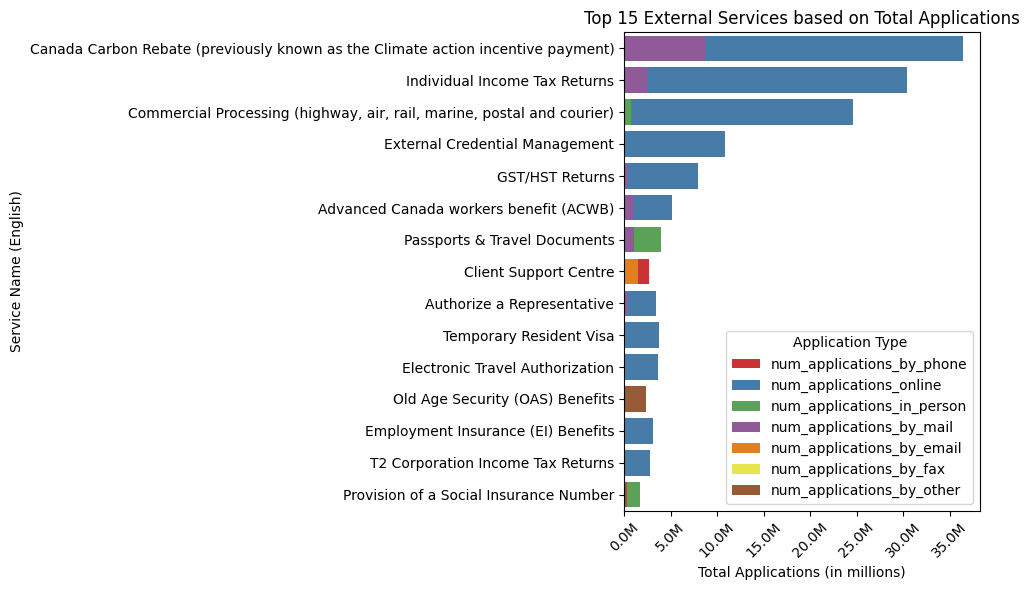

In [ ]:
# plotting top 10 services by applications
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Reshaping the data to long format
top15si_long = topsi_top_15.melt(id_vars=['service_name_en'], 
                            value_vars=['num_applications_by_phone', 'num_applications_online', 
                                         'num_applications_in_person', 'num_applications_by_mail', 
                                         'num_applications_by_email', 'num_applications_by_fax', 'num_applications_by_other'], 
                            var_name='application_type', 
                            value_name='applications')

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top15si_long, x='applications', y='service_name_en', hue='application_type', 
            dodge=False, palette='Set1')

# Format x-axis labels to show in millions
formatter = FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M')  # Format labels in millions
plt.gca().xaxis.set_major_formatter(formatter)

# Set plot labels and title
plt.title('Top 15 External Services based on Total Applications')
plt.xlabel('Total Applications (in millions)')
plt.ylabel('Service Name (English)')
plt.legend(title='Application Type')

# Adjust y-axis label size if needed
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_2123/2850161288.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


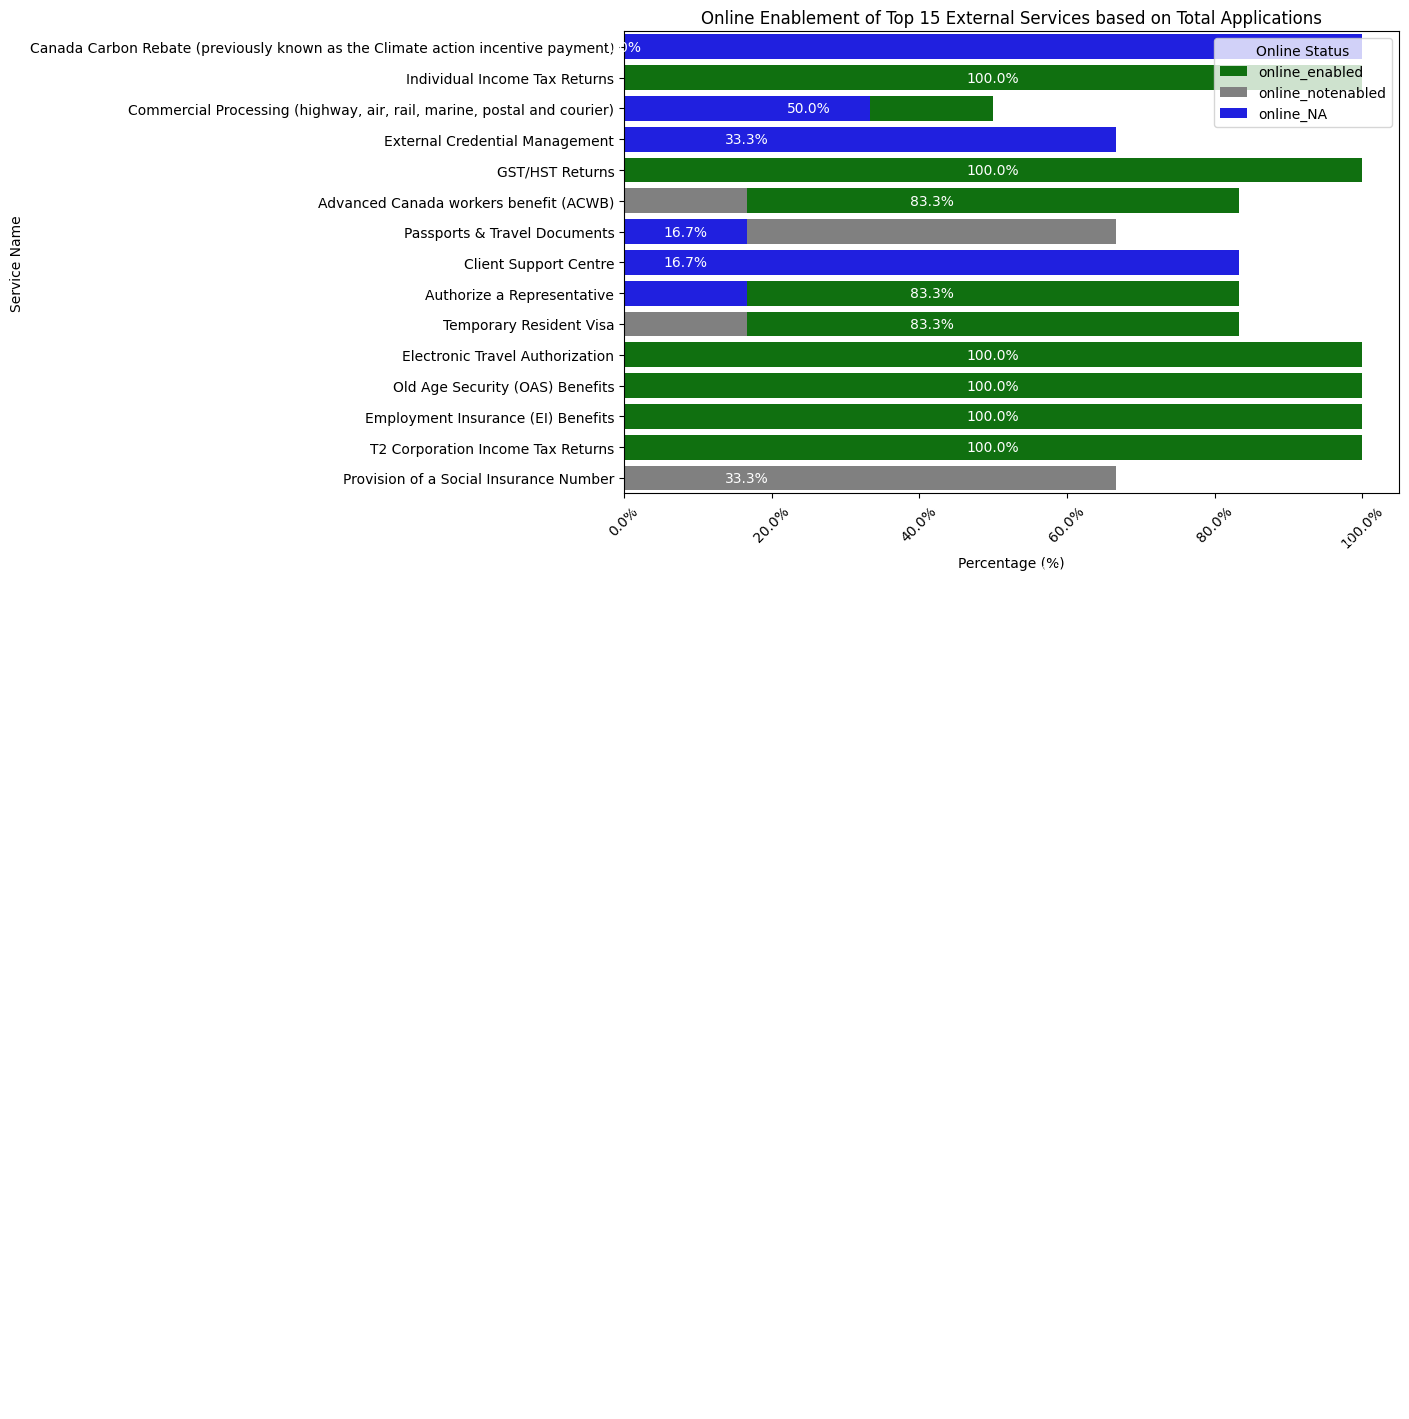

In [ ]:
# to plot the chart for "online enablement of top 15 external services based on total applications"

# Reshaping the data to long format
top15serv_long = top15serv.melt(id_vars=['service_name_en'], 
                                value_vars=['online_enabled', 'online_notenabled', 'online_NA'], 
                                var_name='online_status', 
                                value_name='percentage')

# Normalize the percentages to ensure they sum to 100% for each service
top15serv_long['percentage'] = top15serv_long.groupby('service_name_en')['percentage'].transform(lambda x: x / x.sum() * 100)

# Calculate cumulative sum for stacked bars to position the labels
top15serv_long['cumsum_percentage'] = top15serv_long.groupby('service_name_en')['percentage'].cumsum()

# Create the stacked bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=top15serv_long, x='percentage', y='service_name_en', hue='online_status', 
            dodge=False, palette={'online_enabled': 'green', 
                                   'online_notenabled': 'gray', 
                                   'online_NA': 'blue'})

# Add the data labels
for index, row in top15serv_long.iterrows():
    plt.text(x=row['cumsum_percentage'] - row['percentage'] / 2, 
             y=index, 
             s=f"{round(row['percentage'], 1)}%", 
             color='white', 
             ha='center', va='center', fontsize=10)

# Format x-axis labels to show percentage
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x}%'))

# Set plot labels and title
plt.title('Online Enablement of Top 15 External Services based on Total Applications')
plt.xlabel('Percentage (%)')
plt.ylabel('Service Name')
plt.legend(title='Online Status', loc='upper right')

# Adjust y-axis label size if needed
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()

# Show the plot
plt.show()
